In [1]:
import pyspark

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('cc').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/23 01:06:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/23 01:06:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
pyspark_df = spark.read.format('csv').option('header', 'true').load("/Users/voke/Downloads/PS_20174392719_1491204439457_log.csv")

In [5]:
pyspark_df.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [6]:
pyspark_df.describe().show()

23/04/23 01:06:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+------------------+--------+------------------+-----------+------------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|            amount|   nameOrig|     oldbalanceOrg|   newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+------------------+-----------+------------------+-----------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6362620| 6362620|           6362620|    6362620|           6362620|          6362620|    6362620|           6362620|           6362620|             6362620|             6362620|
|   mean|243.39724563151657|    null|179861.90354913048|       null| 833883.1040744851|855113.6685785787|       null|1100701.6665196505|1224996.3982019336|0.001290820448180152| 2.51468734577894E-6|
| stddev| 

In [7]:
pyspark_df.head()

Row(step='1', type='PAYMENT', amount='9839.64', nameOrig='C1231006815', oldbalanceOrg='170136.0', newbalanceOrig='160296.36', nameDest='M1979787155', oldbalanceDest='0.0', newbalanceDest='0.0', isFraud='0', isFlaggedFraud='0')

In [8]:
pyspark_df.describe('amount').show()

+-------+------------------+
|summary|            amount|
+-------+------------------+
|  count|           6362620|
|   mean|179861.90354913048|
| stddev| 603858.2314629437|
|    min|               0.0|
|    max|          99999.81|
+-------+------------------+



In [26]:
pyspark_df.groupBy('type').count().show()

+--------+-------+
|    type|  count|
+--------+-------+
|TRANSFER| 532909|
| CASH_IN|1399284|
|CASH_OUT|2237500|
| PAYMENT|2151495|
|   DEBIT|  41432|
+--------+-------+



In [11]:
pip install koalas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.8/390.8 kB 8.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 12.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import functools as reduce
from pyspark.context import SparkContext
from pyspark.sql import DataFrame, SQLContext, SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Importing other MLlib Libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import mean, stddev
from pyspark.sql.functions import col, count, isnan, sum
from databricks.koalas.spark import functions as F

In [90]:
print(pyspark.__version__)

3.3.2


In [78]:
pyspark_df.printSchema()

root
 |-- step: string (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: string (nullable = true)
 |-- newbalanceOrig: string (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: string (nullable = true)
 |-- newbalanceDest: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- isFlaggedFraud: string (nullable = true)



In [79]:
pyspark_df.groupby("isFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      0|6354407|
|      1|   8213|
+-------+-------+



In [80]:
pyspark_df.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [81]:
#slicing in pyspark, (Add ".show" to see it, Not showing it now as dataset is 6M rows)
pyspark_df.select(['type', 'isFraud']) 

DataFrame[type: string, isFraud: string]

it is generally a good idea to standardize the amount recorded for transactions in a credit card fraud detection model.

The amount of a transaction can vary widely, and it may be difficult for a machine learning algorithm to differentiate between legitimate transactions and fraudulent ones based on amount alone. By standardizing the transaction amount, you can help the algorithm focus on other features that may be more indicative of fraud, such as transaction frequency, location, or time of day.

Standardization (or normalization) of the amount column can also help with model convergence and performance. Some machine learning algorithms, such as logistic regression or neural networks, are sensitive to the scale of the input features. If the scale of the amount column is much larger than other input features, it may dominate the model and negatively impact its performance. Standardizing the amount column can help to avoid this problem.

In summary, standardizing the amount column can help to improve the performance of a credit card fraud detection model by reducing the impact of transaction amount on the model and allowing it to focus on other features that may be more indicative of fraud.

# standardizing amount

we first use the VectorAssembler to create a vector column containing the values of the "amount" column. We then use the StandardScaler transformer to standardize the "amount_features" column. The resulting standardized column is named "amount_scaled".

The StandardScaler transformer scales each feature to have zero mean and unit variance. This is done by subtracting the mean from each value and dividing by the standard deviation. 

In [61]:
# # The column to be converted is named "amount"
# pyspark_df = pyspark_df.withColumn("amounts", col("amount").cast("int"))

In [31]:
pyspark_df = pyspark_df.drop("step", "isFlaggedFraud", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "nameOrig", "nameDest")

In [32]:
pyspark_df.columns

['type', 'amount', 'isFraud']

In [67]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

In [68]:
# The categorical column is named "type"
indexer = StringIndexer(inputCol="type", outputCol="type_index")
encoder = OneHotEncoder(inputCol="type_index", outputCol="type_onehot")
pipeline = Pipeline(stages=[indexer, encoder])
encoded_df = pipeline.fit(pyspark_df).transform(pyspark_df)

# View the one-hot encoded column
encoded_df.select("type_onehot").show()


+-------------+
|  type_onehot|
+-------------+
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|(4,[3],[1.0])|
|(4,[0],[1.0])|
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|    (4,[],[])|
|    (4,[],[])|
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|(4,[0],[1.0])|
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|(4,[1],[1.0])|
|(4,[3],[1.0])|
+-------------+
only showing top 20 rows



In [69]:
encoded_df.columns

['type', 'amount', 'isFraud', 'type_index', 'type_onehot']

In [70]:
encoded_df.head(10)

[Row(type='PAYMENT', amount='9839.64', isFraud='0', type_index=1.0, type_onehot=SparseVector(4, {1: 1.0})),
 Row(type='PAYMENT', amount='1864.28', isFraud='0', type_index=1.0, type_onehot=SparseVector(4, {1: 1.0})),
 Row(type='TRANSFER', amount='181.0', isFraud='1', type_index=3.0, type_onehot=SparseVector(4, {3: 1.0})),
 Row(type='CASH_OUT', amount='181.0', isFraud='1', type_index=0.0, type_onehot=SparseVector(4, {0: 1.0})),
 Row(type='PAYMENT', amount='11668.14', isFraud='0', type_index=1.0, type_onehot=SparseVector(4, {1: 1.0})),
 Row(type='PAYMENT', amount='7817.71', isFraud='0', type_index=1.0, type_onehot=SparseVector(4, {1: 1.0})),
 Row(type='PAYMENT', amount='7107.77', isFraud='0', type_index=1.0, type_onehot=SparseVector(4, {1: 1.0})),
 Row(type='PAYMENT', amount='7861.64', isFraud='0', type_index=1.0, type_onehot=SparseVector(4, {1: 1.0})),
 Row(type='PAYMENT', amount='4024.36', isFraud='0', type_index=1.0, type_onehot=SparseVector(4, {1: 1.0})),
 Row(type='DEBIT', amount='53

In [71]:
encoded_df = encoded_df.drop("type")

In [72]:
encoded_df.columns

['amount', 'isFraud', 'type_index', 'type_onehot']

In [76]:
encoded_df.printSchema()

root
 |-- amount: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- type_index: double (nullable = false)
 |-- type_onehot: vector (nullable = true)
 |-- amount_int: integer (nullable = true)
 |-- label: integer (nullable = true)



In [77]:
encoded_df = encoded_df.withColumn("amount_int", col("amount").cast("int"))
encoded_df = encoded_df.withColumn("Class", col("isFraud").cast("int"))

In [78]:
encoded_df.printSchema()

root
 |-- amount: string (nullable = true)
 |-- isFraud: string (nullable = true)
 |-- type_index: double (nullable = false)
 |-- type_onehot: vector (nullable = true)
 |-- amount_int: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- Class: integer (nullable = true)



In [79]:
encoded_df = encoded_df.drop("amount", "isFraud")

In [80]:
encoded_df.printSchema()

root
 |-- type_index: double (nullable = false)
 |-- type_onehot: vector (nullable = true)
 |-- amount_int: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- Class: integer (nullable = true)



In [100]:
assembler = VectorAssembler(inputCols=[col for col in encoded_df.columns if col != "Class"],
                           outputCol="features", handleInvalid="skip")

In [101]:
dataset = assembler.transform(encoded_df)

In [102]:
dataset.show(5)

+----------+-------------+----------+-----+-----+--------------------+
|type_index|  type_onehot|amount_int|label|Class|            features|
+----------+-------------+----------+-----+-----+--------------------+
|       1.0|(4,[1],[1.0])|      9839|    0|    0|(7,[0,2,5],[1.0,1...|
|       1.0|(4,[1],[1.0])|      1864|    0|    0|(7,[0,2,5],[1.0,1...|
|       3.0|(4,[3],[1.0])|       181|    1|    1|[3.0,0.0,0.0,0.0,...|
|       0.0|(4,[0],[1.0])|       181|    1|    1|(7,[1,5,6],[1.0,1...|
|       1.0|(4,[1],[1.0])|     11668|    0|    0|(7,[0,2,5],[1.0,1...|
+----------+-------------+----------+-----+-----+--------------------+
only showing top 5 rows



In [103]:
# Since, we only need label and features column for model building. Hence, selecting only relevant columns
model_data = dataset.select(["features", "Class"])
model_data = model_data.withColumnRenamed("Class", "label")
model_data.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|[3.0,0.0,0.0,0.0,...|    1|
|(7,[1,5,6],[1.0,1...|    1|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,5],[4.0,533...|    0|
|(7,[0,5],[4.0,964...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[1,5],[1.0,229...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,2,5],[1.0,1...|    0|
|(7,[0,4,5],[3.0,1...|    0|
+--------------------+-----+
only showing top 20 rows



In [105]:
import matplotlib.pyplot as plt

Training Split at 0.5 %


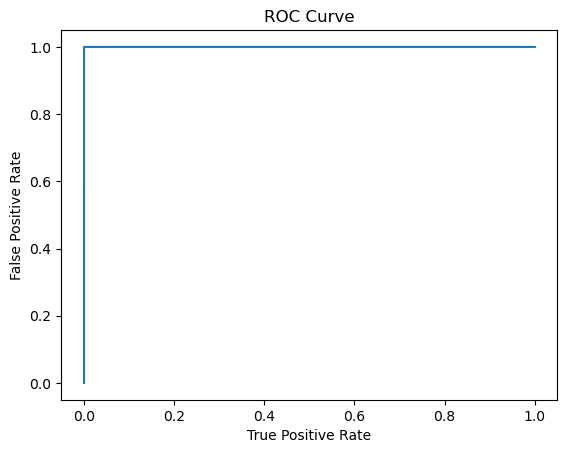

Training set areaUnderCurve: 0.9999887834376426


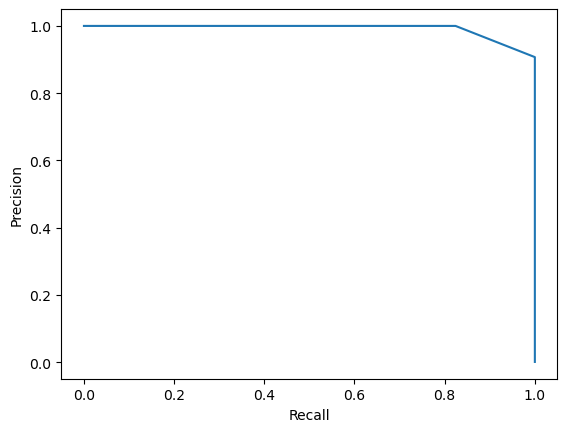

Test Area under ROC 0.9999902328381268


Training Split at 0.55 %


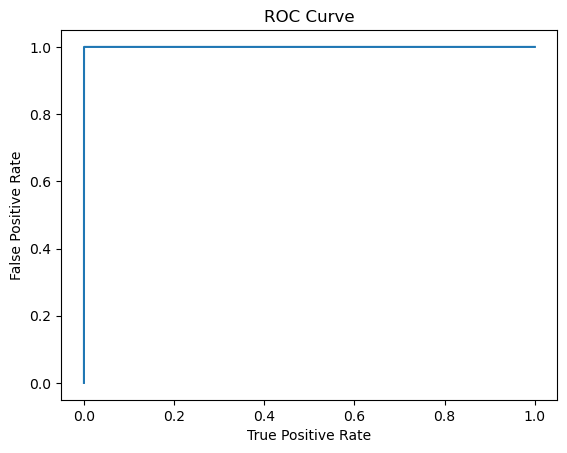

Training set areaUnderCurve: 0.9999982075967454


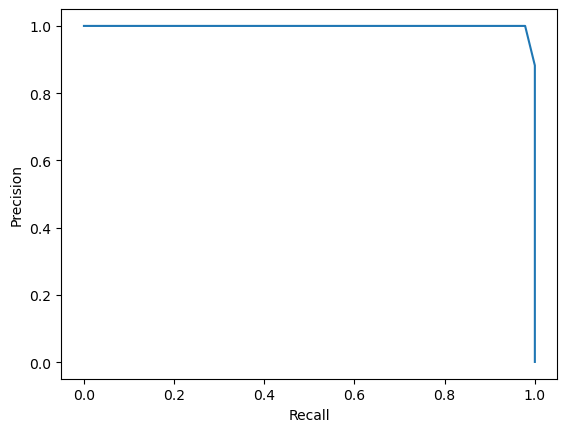

Test Area under ROC 0.9999874738619633


Training Split at 0.6 %


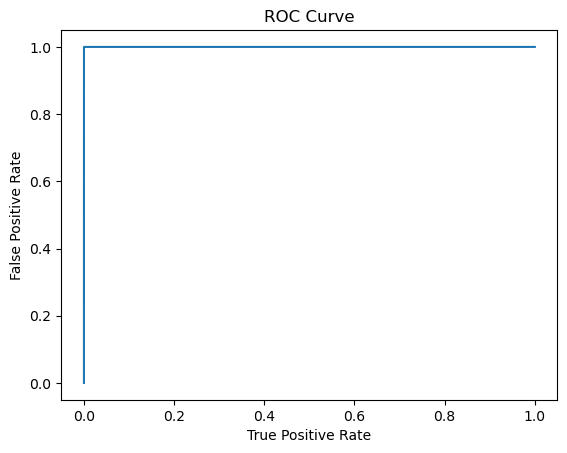

Training set areaUnderCurve: 0.9999989913325458


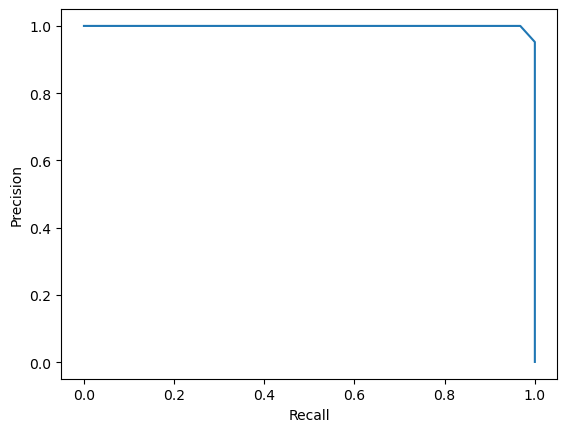

Test Area under ROC 0.9999871992773246


Training Split at 0.65 %


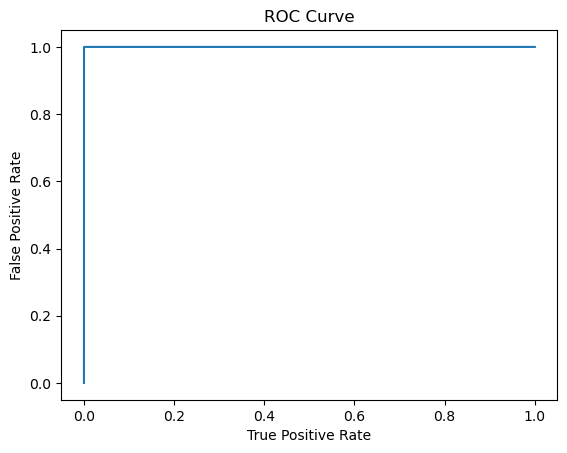

Training set areaUnderCurve: 0.9999966771394583


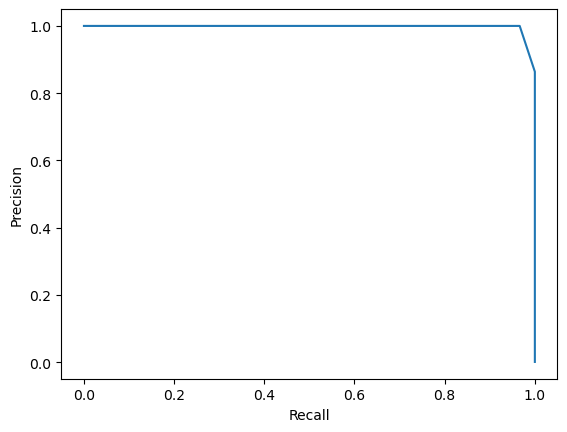

Test Area under ROC 0.9999934056714538


Training Split at 0.7 %


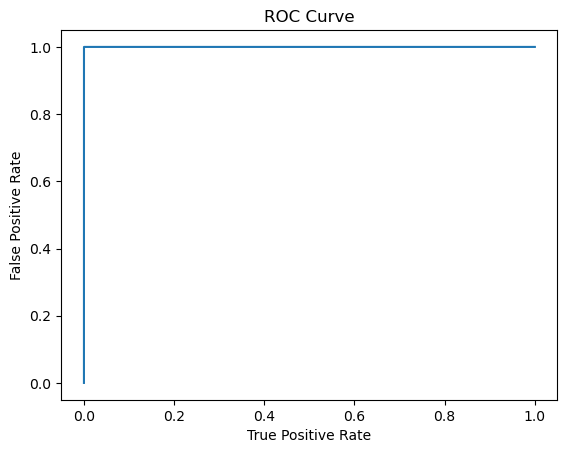

Training set areaUnderCurve: 0.9999963710194294


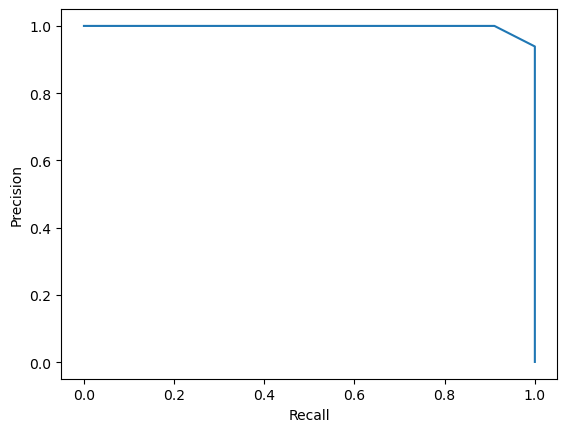

Test Area under ROC 0.99999726951546


Training Split at 0.75 %


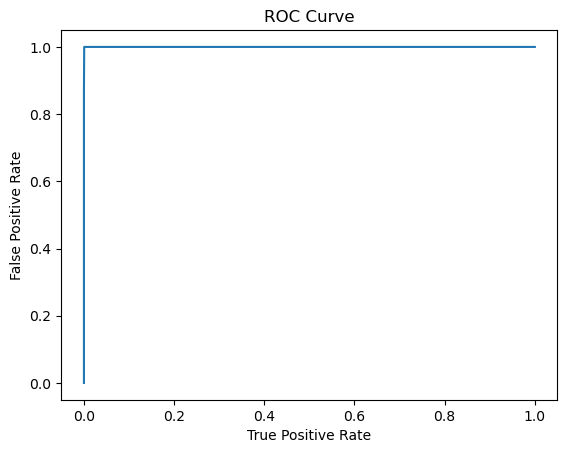

Training set areaUnderCurve: 0.9999627266513401


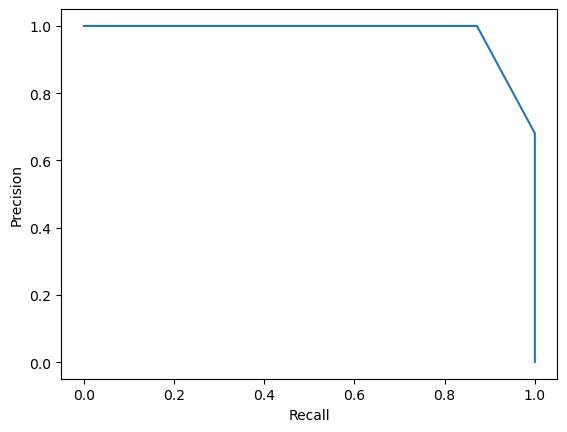

Test Area under ROC 0.9999714121808989


Training Split at 0.8 %


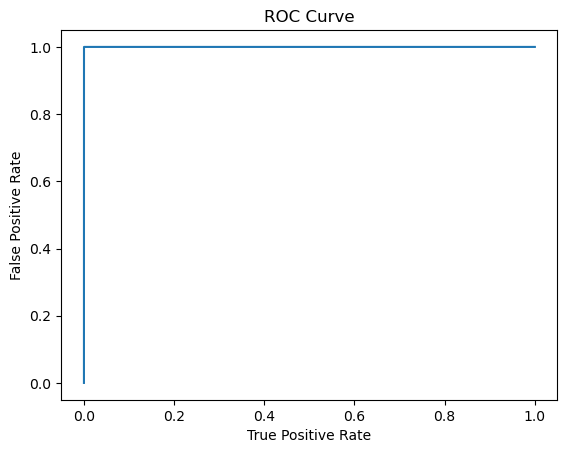

Training set areaUnderCurve: 0.999992433139735


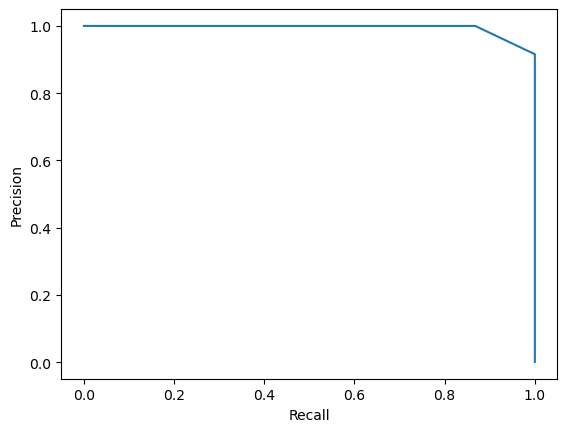

Test Area under ROC 0.9999748481559728


Training Split at 0.85 %


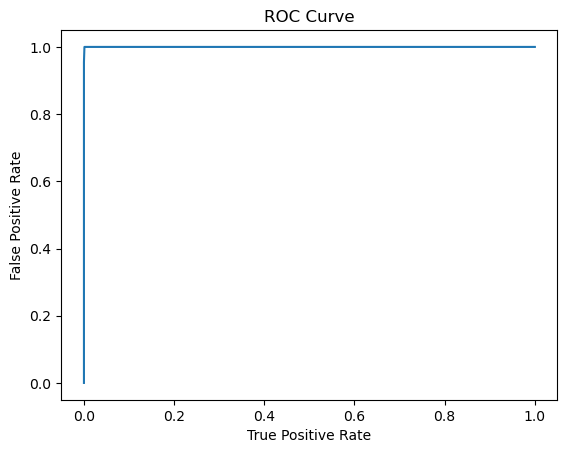

Training set areaUnderCurve: 0.9999752577753696


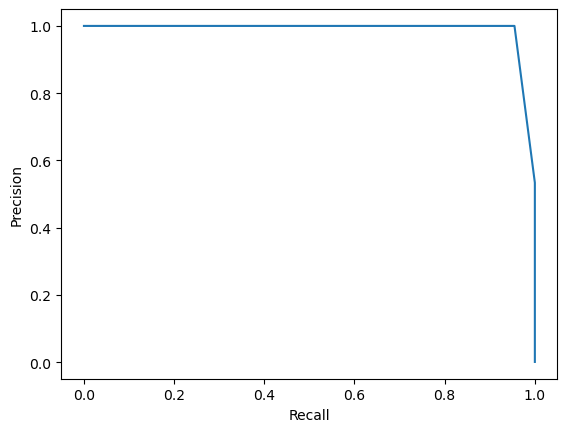

Test Area under ROC 0.9999655715657804


Training Split at 0.9 %


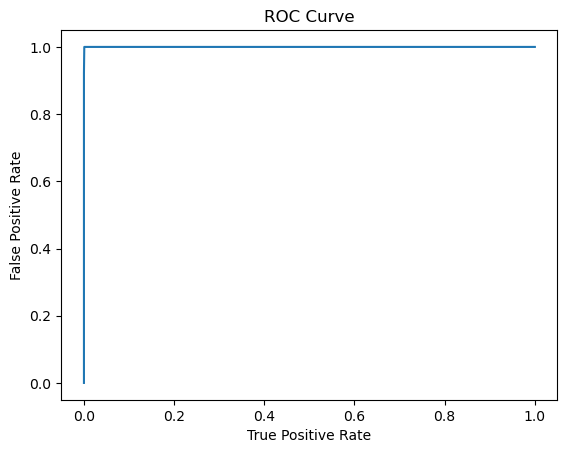

Training set areaUnderCurve: 0.9999704803639619


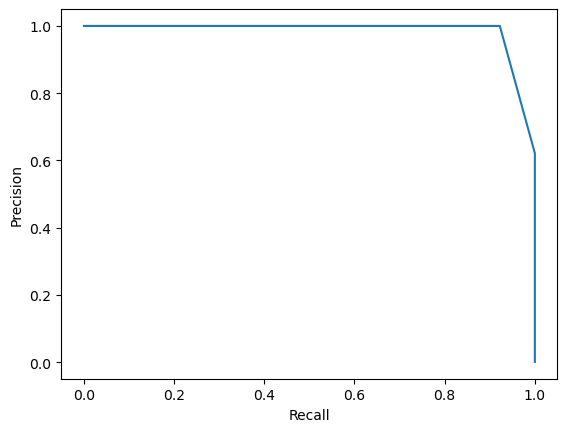

Test Area under ROC 0.999986222590036


Training Split at 0.95 %


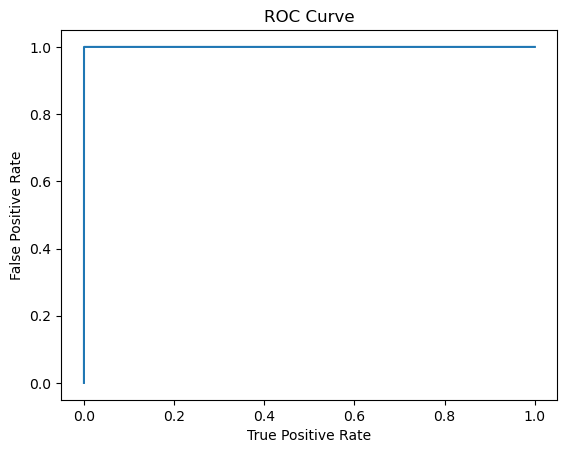

Training set areaUnderCurve: 0.9999947751139321


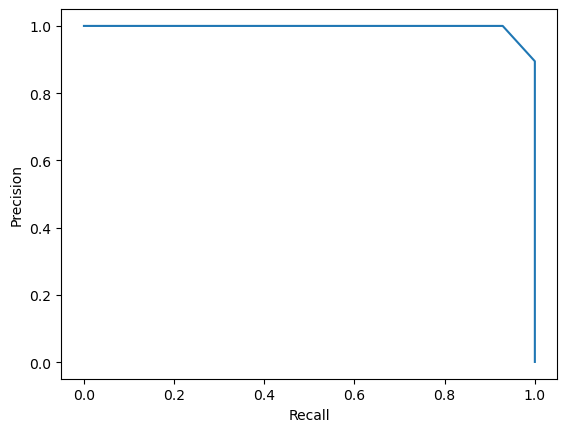

Test Area under ROC 0.9999644886505455


In [106]:
# Model Building
p_train = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]
train_ROC = []
test_ROC = []

for p in p_train:
    
    print("Training Split at", str(p),"%")
    # Splitting the dataset in train and test
    train, test = model_data.randomSplit([p, 1-p])
    lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10000000)
    model = lr.fit(train)

    # Plot on Train dataset
    trainingSummary = model.summary
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc["FPR"], roc["TPR"])
    plt.ylabel("False Positive Rate")
    plt.xlabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()

    print("Training set areaUnderCurve: " + str(trainingSummary.areaUnderROC))
    train_ROC.append(trainingSummary.areaUnderROC)
    
    # Precision Recall Curve
    pr = trainingSummary.pr.toPandas()
    plt.plot(pr["recall"], pr["precision"])
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.show()

    # Evaluating on test dataset
    summary = model.evaluate(test)
    summary.accuracy

    output = model.transform(test)

    evaluator = BinaryClassificationEvaluator()
    print("Test Area under ROC", evaluator.evaluate(output))
    
    test_ROC.append(evaluator.evaluate(output))

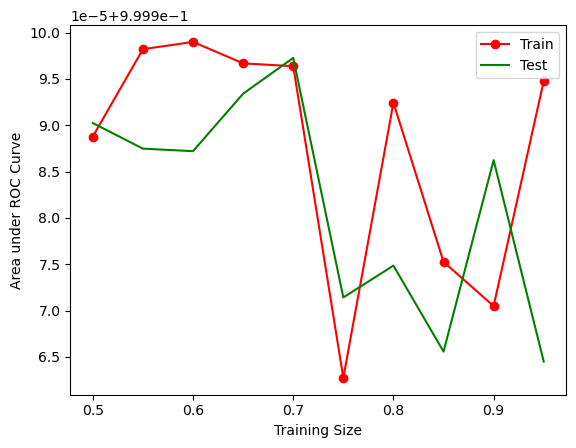

In [107]:
# Plotting
plt.plot(p_train, train_ROC, "ro-", label = "Train")
plt.plot(p_train, test_ROC, "g", label = "Test")
plt.xlabel("Training Size")
plt.ylabel("Area under ROC Curve")
plt.legend()
plt.show()

In [ ]:
Experiment 2

In [64]:
# # Count the number of null values in each column
# pyspark_df.select([count(col(c).isNull().alias(c)) for c in pyspark_df.columns]).show()

# # Count the number of non-null values in each column
# pyspark_df.select([count(col(c).isNotNull().alias(c)) for c in pyspark_df.columns]).show()

In [66]:
# # Count the number of NaN values in the "amounts" column
# df.select(sum(isnan(col("amounts")).cast("integer"))).show()

In [67]:
# # View the mean and standard deviation of the amounts column before scaling
# print("Before scaling:")
# pyspark_df.select(mean("amounts"), stddev("amounts")).show()

# # Scale the amount column
# assembler = VectorAssembler(inputCols=["amounts"], outputCol="amount_features")
# data = assembler.transform(df)

# scaler = StandardScaler(inputCol="amount_features", outputCol="amount_scaled")
# scaler_model = scaler.fit(data)
# scaled_data = scaler_model.transform(data)

# # View the mean and standard deviation of the standardized amount column
# print("After scaling:")
# scaled_data.select(mean("amount_scaled"), stddev("amount_scaled")).show()

By comparing the mean and standard deviation before and after scaling, you can get a sense of the scale of change that occurs when standardizing the "amount" column. If the mean and standard deviation of the standardized "amount" column are close to 0 and 1, respectively, then the scaling has been successful. If the mean and standard deviation are significantly different from 0 and 1, then you may need to adjust the scaling or consider alternative preprocessing methods.